In [230]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as scp

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib as mpl
import csv
from tqdm import notebook
import cmath
import json

In [231]:
class TypeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, complex):
            return {"real": obj.real, "imag": obj.imag}
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)
def as_complex(dct):
    if 'real' in dct and 'imag' in dct:
        return complex(dct['real'], dct['imag'])
    return dct

In [232]:
#Define Constants
e = 1.6e-19 #C - charge on electron
m_e = 9.1094e-31 #kg - mass of electron
al = m_e/e #used in matrix
alin = 1/al
mu_0 = 4e-7*np.pi #H/m - permeability of free space
ep_0 = 8.854e-12 #F/m - permitivity of free space
c = 3e8 #m/s - speed of light

In [233]:
# file = './SetupOG_ReducedRange/38deg_FilterA.json' 
file = './Setup_NoQuartzA/38deg_FilterA.json' 

# file = './Testing/20deg_FilterA.json'
with open(file, 'r') as f:
    jsondata = json.load(f, object_hook=as_complex)
# unpacking:
N = jsondata['N']
L = jsondata['L']
deltax = jsondata['deltax']
wp0 = jsondata['wp0']
thetadegs = jsondata['thetadegs']
theta = jsondata['theta']
Nk = jsondata['Nk']
wmin = jsondata['wmin']
wmax = jsondata['wmax']
k0min = jsondata['k0min']
k0max = jsondata['k0max']
B0 = jsondata['B0']
wc = jsondata['wc']
kzoffset = jsondata['kzoffset']
fp0 = jsondata['fp0']

xlist = jsondata['xlist']
wplist = jsondata['wplist']
eplist = jsondata['eplist']
mulist = jsondata['mulist']

k0list = np.asarray(jsondata['k0list'])
evals_list = list(map(np.array, jsondata['evals_list']))
Eavg_list = list(map(np.array, jsondata['Eavg_list']))
Estd_list = list(map(np.array, jsondata['Estd_list']))
Emax_list = list(map(np.array, jsondata['Emax_list']))

try:
    wgNeg_k0list = np.asarray(jsondata['wgNeg_k0list'])
    wgNeg_distanceList = np.asarray(jsondata['wgNeg_distanceList'])
    wgNeg_evalList = np.asarray(jsondata['wgNeg_evalList'])
    wgNeg_EavgList = jsondata['wgNeg_EavgList']
    wgNeg_EstdList = jsondata['wgNeg_EstdList']
    wgNeg_EmaxList = jsondata['wgNeg_EmaxList']

    wgPos_k0list = np.asarray(jsondata['wgPos_k0list'])
    wgPos_distanceList = np.asarray(jsondata['wgPos_distanceList'])
    wgPos_evalList = np.asarray(jsondata['wgPos_evalList'])
    wgPos_EavgList = jsondata['wgPos_EavgList']
    wgPos_EstdList = jsondata['wgPos_EstdList']
    wgPos_EmaxList = jsondata['wgPos_EmaxList']
except:
    print("No waveguide data")

In [234]:
wgPos_k0list

array([0.02525253, 0.07575758, 0.98484848, 1.03535354, 1.08585859,
       1.13636364, 1.18686869, 1.23737374, 1.28787879, 1.33838384,
       1.38888889, 1.43939394, 1.48989899, 1.54040404, 1.59090909,
       1.64141414, 1.69191919, 1.74242424, 1.79292929, 1.84343434,
       1.89393939, 1.94444444, 1.99494949, 2.04545455, 2.0959596 ,
       2.14646465, 2.1969697 , 2.24747475, 2.2979798 , 2.34848485,
       2.3989899 , 2.44949495, 2.5       ])

### Plot Physical Setup

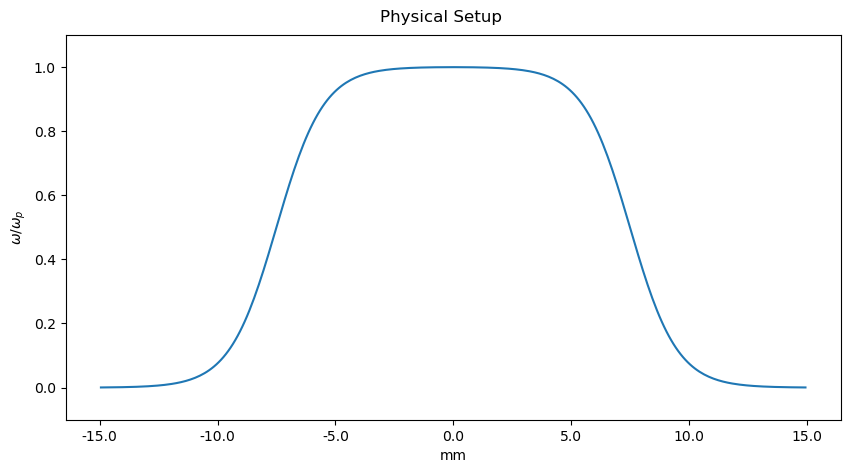

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Physical Setup', y=.93)
ax.plot(xlist, np.divide(wplist, wp0))
for n in range(N):
    if eplist[n] > 1:
        ax.add_patch(patches.Rectangle((xlist[n] - deltax/2, -0.1), deltax, 1.2, color='blue', alpha=0.2, ec=None))
    if eplist[n] < 1:
        ax.add_patch(patches.Rectangle((xlist[n] - deltax/2, -0.1), deltax, 1.2, color='silver', alpha=1, ec=None))
plt.ylim([-0.1,1.1])
xticklist = np.linspace(-L, L, 7)
plt.xticks(xticklist, [round(xt,3) for xt in xticklist*1e3])
plt.xlabel(r'mm')
plt.ylabel(r'$\omega/\omega_p$')
plt.show()

In [236]:
#Bulk modes calculation
def MagPlasmaEigenmodes(sig, kn_x, kn_y, kn_z):
    H = np.array([[0,-sig*1j,0,-1j,0,0,0,0,0],
                  [sig*1j,0,0,0,-1j,0,0,0,0],
                  [0,0,0,0,0,-1j,0,0,0],
                  [1j,0,0,0,0,0,0,kn_z,-kn_y],
                  [0,1j,0,0,0,0,-kn_z,0,kn_x],
                  [0,0,1j,0,0,0,kn_y,-kn_x,0],
                  [0,0,0,0,-kn_z,kn_y,0,0,0],
                  [0,0,0,kn_z,0,-kn_x,0,0,0],
                  [0,0,0,-kn_y,kn_x,0,0,0,0]])
    omn, fn = np.linalg.eig(H)
    #fn = (vn, En, Bn), 9x1 vector
    return [omn.real, fn]

dots = 1000
k0line = np.linspace(k0min,k0max,dots)
ky0line = k0line * np.sin(theta)
kz0line = k0line * np.cos(theta) + kzoffset
bulkLines = np.empty((5,dots))
sig = wc / wp0

for n in range(dots):
    omns = np.sort(MagPlasmaEigenmodes(sig, ky0line[n], 0, kz0line[n])[0])
    for i in range(5):
        bulkLines[i][n] = omns[i+4]

lightline = [np.sqrt(ky0line[i]**2 + kz0line[i]**2) for i in range(dots)]

#Waveguide dispersion
dwg = 6.25e-3
# wpwg = 2 * np.pi * 3.5e9
wpwg = wp0
kpwg = wpwg/c
dispersionload = np.loadtxt("WaveguideDispersion/eps_4.txt")
k0waveguide = dispersionload[:,0]/180 /dwg * np.pi / kpwg
w0waveguide = dispersionload[:,1] * 2 * np.pi * 1e9 / wpwg

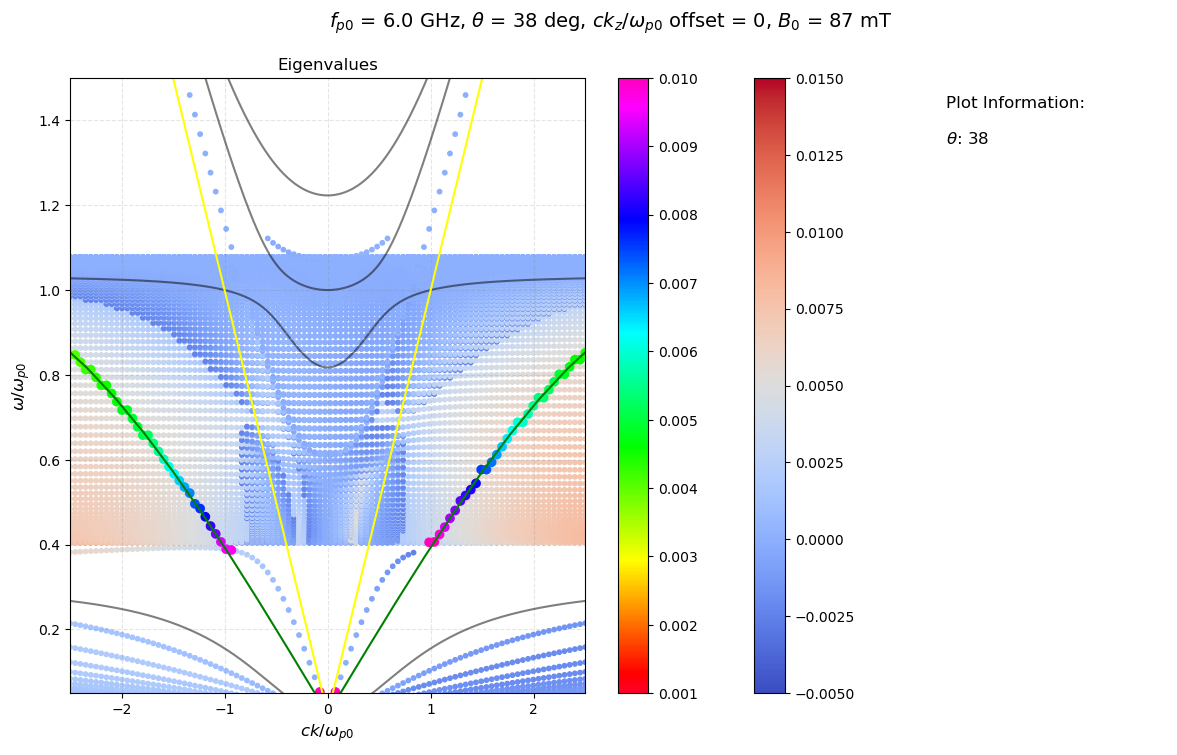

In [237]:
negAvgColorBound = -5e-3
posAvgColorBound = 15e-3

fig, axs = plt.subplot_mosaic([['e', 'e', 'e', 't']],
                              figsize=(12, 7))
fig.tight_layout(pad=2)
fig.suptitle(r'$f_{p0}$' + ' = {} GHz,'.format(fp0 / 1e9) + r' $\theta$ = ' + '{} deg,'.format(thetadegs) + r' $c k_z / \omega_{p0}$ offset'+ r' = {}, $B_0$ = {:.0f} mT'.format(kzoffset, B0 / 1e-3), size=14, y=1.05)

axs['t'].axis('off')

text = rf"""
Plot Information:

$\theta$: {thetadegs}
"""

axs['t'].text(0,1,text, va='top', ha='left', fontsize=12)

axs['e'].set_title('Eigenvalues')
axs['e'].set_xlabel(r'$c k / \omega_{p0}$', size=12)
axs['e'].set_ylabel(r'$\omega / \omega_{p0}$', size=12)


norm = plt.Normalize(negAvgColorBound, posAvgColorBound)
for n in range(len(k0list)):
    sc = axs['e'].scatter([k0list[n] for i in evals_list[n]], evals_list[n].real / wp0, s=10, 
                    c=Eavg_list[n], norm=norm, cmap='coolwarm')
# axs['e'].scatter(k0list[k0id], evals_list[k0id][eval_n].real / wp0, marker='o', s=20, color='lime') #for highlighting
axs['e'].grid(color='gray', linestyle='dashed', alpha=0.2)
axs['e'].set_xlim([k0list[0], k0list[-1]])
axs['e'].set_ylim([wmin / wp0, wmax / wp0])
fig.colorbar(sc, ax=axs['e'], orientation='vertical')

#Plot bulk modes as well
for i in range(len(bulkLines)):
    axs['e'].plot(k0line, bulkLines[i], color='black', alpha=0.5)
#the light line
axs['e'].plot(k0line, lightline, color='yellow')

#Plot waveguide dispersion
axs['e'].plot(k0waveguide, w0waveguide, color='green')
axs['e'].plot(-k0waveguide, w0waveguide, color='green')

try:
    #Plot waveguide intersection points
    # wgNorm = plt.Normalize(7.5e-3,15e-3) # for Eavg
    wgNorm = plt.Normalize(.001,.01) # for Estd - very good for filtering out the correct modes
    # wgNorm = plt.Normalize(0.03,0.12) # for Emax - not that great
    wgCmap = 'gist_rainbow'

    negScatter = axs['e'].scatter(wgNeg_k0list, wgNeg_evalList.real/wp0, marker='o',
                        c=wgNeg_EstdList, norm=wgNorm, cmap=wgCmap)
    posScatter = axs['e'].scatter(wgPos_k0list, wgPos_evalList.real/wp0, marker='o',
                        c=wgPos_EstdList, norm=wgNorm, cmap=wgCmap)
    fig.colorbar(posScatter, ax=axs['e'], orientation='vertical')
except:
    print('error')

plt.show()

In [170]:
np.min(wgPos_EmaxList)

0.03226682359671032